In [48]:
import os, rpy2, scipy
import numpy as np
import pandas as pd
from qiime2 import Artifact
from qiime2.plugins.taxa.methods import collapse
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

datapath = '../data'

# Read data

In [49]:
## metadata
bombusMeta = pd.read_csv(os.path.join(datapath,'BombusMetadata.tsv'), sep='\t',
                        index_col=0)
bombusMeta['species'] =bombusMeta['species'].replace({'fer':'bor'})
##wu 
wu_df = pd.read_csv(os.path.join(datapath, 'dm/wudf.csv'), index_col=0)
## Genus level 
taxa_6 = pd.read_csv(os.path.join(datapath, 'table/genus_table.tsv'), 
                     index_col=0, sep = '\t')
taxa_6_norm = (taxa_6/taxa_6.sum(axis =0)).transpose()
# Class level
taxa_3 = pd.read_csv(os.path.join(datapath, 'table/class_table.tsv'), 
                     index_col=0, sep = '\t')
taxa_3_norm = (taxa_3/taxa_3.sum(axis =0)).transpose()

## create pretty colormap

### 1) optimal ordering of ASVs

In [278]:
from qiime2 import Artifact
rooted_tree=Artifact.load(os.path.join(datapath, 'qiime/rooted_tree.qza'))
from skbio import TreeNode
tree = rooted_tree.view(TreeNode)

# Get all leaves
leaves = list(tree.tips())

## filter leaves
totaxa = pd.read_csv(os.path.join(datapath, 'table/ensemble_taxa.tsv'), sep = '\t',
                   index_col=0)
def filter_leaves(leaf):
    # 1) get the name 
    asv = leaf.name
    name = 'd__'+totaxa.loc[asv, 'Domain']
    if not pd.isna(totaxa.loc[asv, 'Phylum']):
        name += ';p__'+totaxa.loc[asv, 'Phylum']
        if not pd.isna(totaxa.loc[asv, 'Class']):
            name += ';c__'+totaxa.loc[asv, 'Class']
            if not pd.isna(totaxa.loc[asv, 'Order']):
                name += ';o__'+totaxa.loc[asv, 'Order']
                if not pd.isna(totaxa.loc[asv, 'Family']):
                    name += ';f__'+totaxa.loc[asv, 'Family']
                if not pd.isna(totaxa.loc[asv, 'Genus']):
                    name += ';g__'+totaxa.loc[asv, 'Genus']
                
                if name in taxa_6_norm.columns and (taxa_6_norm.loc[bombusMeta.index, name] >0).mean() > 0.1:
                    return leaf

# Compute pairwise distances between tips
import numpy as np
from scipy.spatial.distance import pdist, squareform
import multiprocess as mp
def patristic_distance_matrix(tree, leaves):
    chosen_leaves = [x for x in [filter_leaves(x) for x in leaves] if x is not None]
    n = len(chosen_leaves)
    matrix = np.zeros((n, n))
    pairings = []
    for i in range(n):
        for j in range(i+1, n):
            pairings.append([i,j])
    getdist = lambda x: chosen_leaves[x[0]].distance(chosen_leaves[x[1]])
    with mp.Pool(10) as pool:
        dists = list(pool.map(getdist, pairings))
    for x in range(len(pairings)):
        matrix[pairings[x][0], pairings[x][1]] = dists[x]
        matrix[pairings[x][1], pairings[x][0]] = dists[x]
    # for i in range(n):
    #     for j in range(n):
    #         if i != j:
    #             matrix[i, j] = leaves[i].distance(leaves[j])
    return chosen_leaves, matrix


chosen_leaves, dist_matrix = patristic_distance_matrix(tree, leaves)
leaf_names = [x.name for x in chosen_leaves]
# Apply PCA to reduce the distance to 1D (for colormap mapping)
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
leaf_coords = pca.fit_transform(dist_matrix)
leaf_coords = (leaf_coords - leaf_coords.min()) / (leaf_coords.max() - leaf_coords.min())  # normalize [0,1]


### 2) group into genera

In [279]:
taxa_colors = pd.DataFrame(leaf_coords, index = leaf_names,
     columns = ['coord']).join(pd.read_csv(os.path.join(datapath, 'table/ensemble_taxa.tsv'), sep = '\t',
                   index_col=0))
### add families as well 
genus_colors = pd.concat([taxa_colors[~taxa_colors['Genus'].isna()][['coord','Genus']].rename(columns = {'Genus':'taxa'}),
           taxa_colors[(~taxa_colors['Family'].isna()) & (taxa_colors['Genus'].isna())][['coord','Family']].rename(columns = {'Family':'taxa'})])
genus_colors = genus_colors.groupby('taxa')['coord'].median().sort_values()
genus_colors = (genus_colors - genus_colors.min()) / (genus_colors.max() - genus_colors.min())

of_interest = list(map(lambda x: x.split('__')[-1].strip(';'),
        taxa_6_norm.mean().sort_values()[-15:].index))

def get_code(t):
    if t in genus_colors.index:
        return genus_colors.loc[t]
    else:
        return np.nan
codes = list(map(get_code, of_interest))
sorted(codes)

[0.010958899824339497,
 0.018031336048347116,
 0.02292205180096831,
 0.023686394516180678,
 0.07049659114301637,
 0.07205814281744993,
 0.08757241415712923,
 0.10156368352374757,
 0.22031070596219843,
 0.22292576277538975,
 0.27510076526614496,
 0.29176866671641194,
 0.3459770355238221,
 0.36053595466202804,
 0.44327669540549863]

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_63987/2003906143.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Spectral')


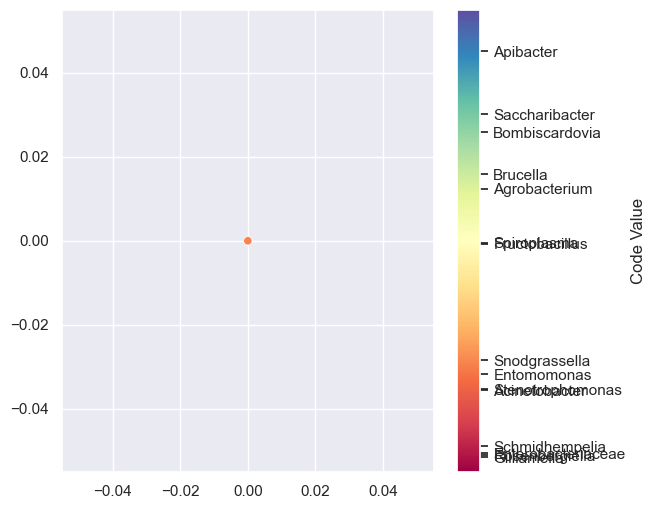

In [268]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import numpy as np
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize = (6,6))
norm = Normalize(vmin=0, vmax=.5)
cmap = get_cmap('Spectral')
colors = cmap(norm(codes))

sns.scatterplot(x = np.zeros(len(codes)), y = np.zeros(len(codes)), hue = codes,
                palette = cmap, legend = False)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Code Value")

cbar.set_ticks(codes)
cbar.set_ticklabels(of_interest)


# Look at relationship between infection and alpha diversity

/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


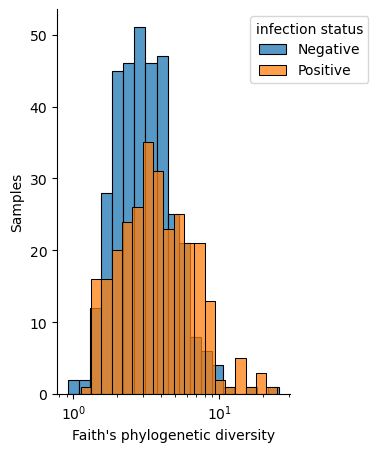

In [50]:
fig, ax = plt.subplots(figsize = (3,5))
plt.xscale('log')
sns.histplot(data = bombusMeta[bombusMeta['Positive'] ==0], x = 'faithpd', 
            label = 'Negative')
sns.histplot(data = bombusMeta[bombusMeta['Positive'] ==1], x = 'faithpd', 
            label = 'Positive', bins = 19)
plt.xlabel("Faith's phylogenetic diversity")
plt.ylabel("Samples")
plt.legend(title = 'infection status')
sns.move_legend(ax, "upper left", bbox_to_anchor=(.8, 1))
sns.despine()
fig.savefig('figs/faith_pd.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

In [7]:
scipy.stats.mannwhitneyu(bombusMeta[bombusMeta['Positive'] ==0]['faithpd'].dropna(), bombusMeta[bombusMeta['Positive'] ==1]['faithpd'].dropna())

MannwhitneyuResult(statistic=39204.5, pvalue=9.339282276007313e-06)

# Relationship between infection and bee metadata 

pglmms implemented in r package phyr

## logistic regression for positivity

Create r-safe dataframe with species names changed to match tree

In [51]:
rdf=bombusMeta[['Positive','faithpd',
            'days_Since_May1', 'caste','species','site_year']].copy()
rdf['species'] = rdf['species'].replace({'bim':'B._bimaculatus','tern':'B._ternarius',
                'vag':'B._vagans','imp':'B._impatiens','bor':'B._borealis',
                               'terri':'B._terricola', 'ruf':'B._rufocinctus',
                       'per':'B._perplexus', 'san':'B._sandersoni',
                       'gris':'B._griseocollis'})

**Run logistic regression in R**
- (1|species__) = phylogenetic random effect
- infections increase with date 

In [52]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [53]:
%%R -i rdf

# read in the tree
library(ape)
bombustree <- ape::read.tree('../data/tree')

# run the model 
library(phyr)
rdf$caste<- relevel(as.factor(rdf$caste), ref ='W')
full_pglmm <- pglmm(Positive ~ days_Since_May1 + caste  +(1|species__) + (1|site_year),
      data = rdf,
      family = "binomial",
      cov_ranef = list(species=bombustree))

print(summary(full_pglmm))

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable species



Generalized linear mixed model for binomial data fit by restricted maximum likelihood

Call:Positive ~ days_Since_May1 + caste

logLik    AIC    BIC 
-382.6  781.1  807.6 

Random effects:
             Variance Std.Dev
1|species   0.1707454 0.41321
1|species__ 0.0001881 0.01371
1|site_year 1.1135984 1.05527

Fixed effects:
                    Value Std.Error  Zscore    Pvalue    
(Intercept)     -2.270077  0.464244 -4.8898 1.009e-06 ***
days_Since_May1  0.025800  0.005433  4.7488 2.046e-06 ***
casteM          -0.324711  0.312898 -1.0378    0.2994    
casteQ          -0.137875  0.459968 -0.2997    0.7644    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

NULL


**Run likelihood ratio tests for random effects**
- collection site and non-phylogenetic species effects significant, phylogenetic effect not

In [54]:
%%R
LRTs <- sapply(1:3, FUN = function(x) pglmm_profile_LRT(full_pglmm, re.number = x))

colnames(LRTs) <- names(full_pglmm$ss)
t(LRTs)

            LR            df Pr          
1|species   5.04083       1  0.0007487618
1|species__ -0.0002863152 1  1           
1|site_year 26.51013      1  1.650631e-13


### look at conservation status as a predictor

add national scores. Not a ton of variation between species

In [8]:
#national
nat = {'gris':5,
 'bim':5,
 'imp':5,
 'vag':4,
 'san':4.5,
 'bor':4.5,
 'per':5,
 'ruf':4.5,
 'tern':5,
 #NU unknown national
 'terri':3.5}

rdf = rdf.join(pd.DataFrame(bombusMeta['species'\
            ].replace(nat)).rename(columns={'species':'status'}))
##change to inverse so that 5 (no conservation) is 0. 
rdf['status_inverse'] = (rdf['status']*-1) + 5

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_63987/1874398132.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].replace(nat)).rename(columns={'species':'status'}))


No change to the results

In [9]:
%%R -i rdf
rdf$caste<- relevel(as.factor(rdf$caste), ref ='W')
full_pglmm_status <- pglmm(Positive ~ days_Since_May1 + caste+status_inverse+ (1|species__) + (1|site_year),
      data = rdf,
      family = "binomial",
      cov_ranef = list(species=bombustree))

print(summary(full_pglmm_status))

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable species



Generalized linear mixed model for binomial data fit by restricted maximum likelihood

Call:Positive ~ days_Since_May1 + caste + status_inverse

logLik    AIC    BIC 
-381.9  781.8  811.6 

Random effects:
             Variance  Std.Dev
1|species   2.056e-01 0.453481
1|species__ 5.921e-05 0.007695
1|site_year 1.101e+00 1.049380

Fixed effects:
                     Value  Std.Error  Zscore   Pvalue    
(Intercept)     -2.3047259  0.5087352 -4.5303 5.89e-06 ***
days_Since_May1  0.0260269  0.0054611  4.7659 1.88e-06 ***
casteM          -0.3299624  0.3138676 -1.0513   0.2931    
casteQ          -0.1265098  0.4605247 -0.2747   0.7835    
status_inverse   0.0367135  0.4013780  0.0915   0.9271    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

NULL


### increase over the summer

In [8]:
bombusMeta['Positive'].std()

0.49832028402018974

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_9953/4261780743.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xticks, avg_props, color='#206ea9', alpha=1, cmap = 'tab10', s=8)


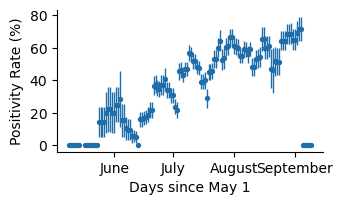

In [9]:
xticks = np.arange(bombusMeta['days_Since_May1'].min(), bombusMeta['days_Since_May1'].max())
def get_avg(day, win=5):
    subset = bombusMeta[(bombusMeta['days_Since_May1'] - day)**2 <= win**2]
    if len(subset) <3:
        return np.nan, np.nan

    p = subset['Positive'].mean()
    n = len(subset)
    return 100*p, 100*(p * (1-p) / n)**0.5

avg_props, avg_stds = np.vectorize(lambda x: get_avg(x))(xticks)

fig, ax = plt.subplots(figsize=(205.6846/60, 110.3311/60))
plt.scatter(xticks, avg_props, color='#206ea9', alpha=1, cmap = 'tab10', s=8)
plt.errorbar(xticks, avg_props, yerr=avg_stds, fmt='none', color='#206ea9',alpha=1,linewidth=1)
plt.xlabel('Days since May 1')
plt.ylabel('Positivity Rate (%)')
plt.xticks([31,61,92,123], labels = ['June', 'July', 'August', 'September'])
sns.despine()
fig.savefig('figs/dayosummer_positivity.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')


### lat/lon

In [14]:
rdf=bombusMeta[['Positive','faithpd',
            'days_Since_May1', 'caste','species','site_year', 
            'Latitude', 'Longitude']].copy()
rdf['species'] = rdf['species'].replace({'bim':'B._bimaculatus','tern':'B._ternarius',
                'vag':'B._vagans','imp':'B._impatiens','bor':'B._borealis',
                               'terri':'B._terricola', 'ruf':'B._rufocinctus',
                       'per':'B._perplexus', 'san':'B._sandersoni',
                       'gris':'B._griseocollis'})


In [19]:
%%R -i rdf

# read in the tree
library(ape)
bombustree <- ape::read.tree('../data/tree')

# run the model 
library(phyr)
rdf$caste<- relevel(as.factor(rdf$caste), ref ='W')
full_pglmm <- pglmm(Positive ~ days_Since_May1 + caste +Latitude +Longitude +(1|species__) + (1|site_year),
      data = rdf,
      family = "binomial",
      cov_ranef = list(species=bombustree))

print(summary(full_pglmm))

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable species



Generalized linear mixed model for binomial data fit by restricted maximum likelihood

Call:Positive ~ days_Since_May1 + caste + Latitude + Longitude

logLik    AIC    BIC 
-308.4  636.9  668.7 

Random effects:
            Variance Std.Dev
1|species    0.01169  0.1081
1|species__  0.11583  0.3403
1|site_year  0.67105  0.8192

Fixed effects:
                      Value   Std.Error  Zscore    Pvalue    
(Intercept)     109.6483529  23.5621080  4.6536 3.262e-06 ***
days_Since_May1   0.0224238   0.0060725  3.6927 0.0002219 ***
casteM           -0.2321386   0.3277814 -0.7082 0.4788138    
casteQ           -0.1854605   0.4946176 -0.3750 0.7076923    
Latitude         -1.8785311   0.4106917 -4.5741 4.783e-06 ***
Longitude         0.4096643   0.1878319  2.1810 0.0291823 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

NULL


In [20]:
%%R
LRTs <- sapply(1:3, FUN = function(x) pglmm_profile_LRT(full_pglmm, re.number = x))

colnames(LRTs) <- names(full_pglmm$ss)
t(LRTs)

            LR          df Pr          
1|species   0.008850067 1  0.4470801   
1|species__ 1.310698    1  0.05271584  
1|site_year 8.806067    1  1.354274e-05


## regression for infection severity

pull out samples for which we have a parasite concentration

In [10]:
rdf2 = bombusMeta[bombusMeta['CBombiConc']>0][['CBombiConc','Positive',
            'days_Since_May1', 'caste','species','site_year']].copy()
rdf2['species'].replace({'bim':'B._bimaculatus','tern':'B._ternarius',
                'vag':'B._vagans','imp':'B._impatiens','bor':'B._borealis',
                               'terri':'B._terricola', 'ruf':'B._rufocinctus',
                       'per':'B._perplexus', 'san':'B._sandersoni',
                        'gris':'B._griseocollis'},inplace = True)
rdf2['logCBombi'] = rdf2['CBombiConc'].transform(np.log)

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_9953/2947282748.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rdf2['species'].replace({'bim':'B._bimaculatus','tern':'B._ternarius',


Caste might have a weak relationship with infection load. Not strong enough to hold up against multiple testing correction, though

In [11]:
%%R -i rdf2
rdf2$caste<- relevel(as.factor(rdf2$caste), ref ='W')
full_pglmm_load <- pglmm(logCBombi ~ days_Since_May1 + caste+ (1|species__) + (1|site_year),
      data = rdf2,
      family = "gaussian",
      cov_ranef = list(species=bombustree),
                   )
#AIC(full_pglmm)
print(summary(full_pglmm_load))

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable species



Linear mixed model fit by restricted maximum likelihood

Call:logCBombi ~ days_Since_May1 + caste

logLik    AIC    BIC 
 -1379   2774   2799 

Random effects:
             Variance  Std.Dev
1|species   9.029e-05 0.009502
1|species__ 1.208e+00 1.099092
1|site_year 3.338e+00 1.826943
residual    1.102e+01 3.319625

Fixed effects:
                     Value  Std.Error  Zscore   Pvalue   
(Intercept)      2.3886662  1.0490448  2.2770 0.022787 * 
days_Since_May1  0.0294521  0.0089746  3.2817 0.001032 **
casteM          -0.9683002  0.5000358 -1.9365 0.052811 . 
casteQ          -1.6965450  0.7349120 -2.3085 0.020971 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

NULL


Likelihood ratio tests

In [12]:
%%R
LRTs <- sapply(1:4, FUN = function(x) pglmm_profile_LRT(full_pglmm_load, re.number = x))

colnames(LRTs) <- names(full_pglmm_load$ss)
t(LRTs)

            LR            df Pr          
1|species   -5.568888e-05 1  1           
1|species__ 9.443116      1  6.937526e-06
1|site_year 25.20046      1  6.2668e-13  
residual    0             1  1           


# Relationships between infection and specific taxa

## run differential abundance tests

Write preprocessed relative abundance tables

In [55]:
bombusMeta['log_CBombi'] = bombusMeta['CBombiConc'].transform(np.log)
bombusMeta['sp'] =bombusMeta['species'].replace({'bim':'B._bimaculatus','tern':'B._ternarius',
                'vag':'B._vagans','imp':'B._impatiens','bor':'B._borealis',
                               'terri':'B._terricola', 'ruf':'B._rufocinctus',
                       'per':'B._perplexus', 'san':'B._sandersoni',
                               'gris':'B._griseocollis'})

if not os.path.isdir('../data/crithidia_results'):
    os.mkdir('../data/crithidia_results')
    
def log_pseudo_trans(col):
    '''
    ln transforms a continuous variable, after pseudocounting zeros 
    with 1/2 the smallest non-zero value 
    '''
    pseudo = col[col>0].min()/2
    return col.replace(0, pseudo).transform(np.log)

def create_table(prev_cut=0.1, table= taxa_6_norm, depth = 6,transform = log_pseudo_trans ):
    table = table.copy().drop(columns = [x for x in table.columns if x.startswith('Unassigned;')]).copy()
    passing_taxa = table.apply(lambda x: x>0).sum()[\
    table.apply(lambda x: x>0).sum() >prev_cut*table.shape[0]].index
    passing_taxa = [x for x in passing_taxa if len(x.split(';'))==depth]
    df = table[passing_taxa].copy()
    df['other'] = 1 - df.sum(axis=1)
    for d in df.columns:
        df[d] = df[d].transform(transform)
    return df


df = create_table()
df = pd.merge(pd.melt(df.reset_index(), id_vars='index',var_name='taxa',
        value_name='log_ra').rename(columns = {'index':'sample'}),
    bombusMeta[['sp', 'caste', 'site_year','log_CBombi',
            'CBombiConc', 'Positive','days_Since_May1', 'Latitude', 'Longitude']],
         left_on='sample', right_index=True)

df.to_csv('../data/crithidia_results/df.tsv', sep = '\t')
df['ra'] =df['log_ra'].apply(lambda x: np.exp(x))

df2 = create_table(table=taxa_3_norm, depth =3)
df2 = pd.merge(pd.melt(df2.reset_index(), id_vars='index',var_name='taxa',
        value_name='log_ra').rename(columns = {'index':'sample'}),
    bombusMeta[['sp', 'caste', 'site_year','log_CBombi',
            'CBombiConc', 'Positive','days_Since_May1', 'Latitude', 'Longitude']],
         left_on='sample', right_index=True)

df2.to_csv('../data/crithidia_results/df_3.tsv', sep = '\t')

Write tables with just samples with parasite load estimates. 

In [56]:
df_pos = create_table(table = taxa_6_norm.loc[bombusMeta[bombusMeta['CBombiConc']>0].index].copy())
df_pos = pd.merge(pd.melt(df_pos.reset_index(), id_vars='index',var_name='taxa',
        value_name='log_ra').rename(columns = {'index':'sample'}),
    bombusMeta[['sp', 'caste', 'site_year','log_CBombi',
            'CBombiConc', 'Positive','days_Since_May1', 'Latitude', 'Longitude']],
         left_on='sample', right_index=True)

df_pos.to_csv('../data/crithidia_results/df_pos.tsv', sep = '\t')

df3_pos = create_table(table=taxa_3_norm.loc[bombusMeta[bombusMeta['CBombiConc']>0].index].copy(), depth = 3)
df3_pos = pd.merge(pd.melt(df3_pos.reset_index(), id_vars='index',var_name='taxa',
        value_name='log_ra').rename(columns = {'index':'sample'}),
    bombusMeta[['sp', 'caste', 'site_year','log_CBombi',
            'CBombiConc', 'Positive','days_Since_May1', 'Latitude', 'Longitude']],
         left_on='sample', right_index=True)

df3_pos.to_csv('../data/crithidia_results/df3_pos.tsv', sep = '\t')

**Run models in R**

In [57]:
%%R 
library(phyr)
library(ape)
bombustree <- ape::read.tree('../data/tree')
writedir <-'../data/crithidia_results/'

run_model <- function(taxa, model='Pos', prefix='genus'){
    # create dataframe
    tdf<-df[which(df$taxa==t),]
    tdf$log_days <-log(tdf$days_Since_May1)
    if(model=='infection_strength'){
        tdf <-tdf[which(tdf$CBombiConc>0),]
        }
    # run model 
    if(model=='infection_strength'){
        full_pglmm <- pglmm(log_ra ~ days_Since_May1 + log_CBombi + Latitude + Longitude + (1|sp__) + (1|site_year),
      data = tdf,family = "gaussian",cov_ranef = list(sp=bombustree), 
                        verbose = FALSE )
        }
    else{
        full_pglmm <- pglmm(log_ra ~ days_Since_May1 + Positive + Latitude + Longitude + (1|sp__) + (1|site_year),
      data = tdf,family = "gaussian",cov_ranef = list(sp=bombustree), 
                        verbose = FALSE )
        }
    # write results
    if (!is.null(full_pglmm)) {
        if(model=='infection_strength'){
            sink(paste0(writedir, prefix, '.',  taxa, '.strength.txt'))
            }
        else{
            sink(paste0(writedir, prefix, '.', taxa, '.txt'))
            }
        summary(full_pglmm)
        LRTs <- sapply(1:4, FUN = function(x) phyr::pglmm_profile_LRT(full_pglmm, re.number = x))
        colnames(LRTs) <- names(full_pglmm$ss)
        print(t(LRTs))
        sink()
        }
    }

df <- read.csv('../data/crithidia_results/df.tsv',
               sep ='\t', row.names=1)
for (t in unique(df$taxa)){
    run_model(t, prefix='genus')
    }
                       
df <- read.csv('../data/crithidia_results/df_3.tsv',
               sep ='\t', row.names=1)
for (t in unique(df$taxa)){
    run_model(t, prefix='class')
    }

df <- read.csv('../data/crithidia_results/df_pos.tsv',
               sep ='\t', row.names=1)
for (t in unique(df$taxa)){
    run_model(t, 'infection_strength', prefix='genus')
    }
                       
df <- read.csv('../data/crithidia_results/df3_pos.tsv',
               sep ='\t', row.names=1)

for (t in unique(df$taxa)){
    run_model(t, 'infection_strength', prefix='class')
    }

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species

## read in 

Create a dictionary of results dataframes
- separate entries for positive/severity testing
- genus and class level taxa included in same dfs

In [24]:
res=['1|sp', '1|sp__', '1|site_year', 'residual']
restats = ['Variance', 'LRT Pvalue']
fes= {'positive':['(Intercept)', 'days_Since_May1', 'Positive', 'Latitude', 'Longitude'],
      'load':['(Intercept)', 'days_Since_May1', 'log_CBombi', 'Latitude', 'Longitude']}
stats= ['Value','Std.Error','Zscore','Pvalue']


dfs = {'positive':pd.DataFrame(columns = ['level'] +\
        [a for b in [[" ".join([a,b]) for b in restats] for a in res] for a in b] + \
            [a for b in [[" ".join([a,b]) for b in stats] for a in fes['positive']] for a in b]),
       'load':pd.DataFrame(columns = ['level'] +\
        [a for b in [[" ".join([a,b]) for b in restats] for a in res] for a in b] + \
            [a for b in [[" ".join([a,b]) for b in stats] for a in fes['load']] for a in b])}

for f in [os.path.join('../data/crithidia_results', f) for f in os.listdir('../data/crithidia_results') \
          if not f.startswith('df')]:
    if 'strength' in f:
        df = dfs['load']
        fe = fes['load']
    else:
        df = dfs['positive']
        fe = fes['positive']
        
    name = f.split('/')[3].split(';')
    level = name[0].split('.')[0]
    
    if 'other' in name:
        name ='other'
        
    else:
        name = list(map(lambda x: x.replace(level+'.', '').replace('.txt',
                '').replace('.strength',''), name))
        for i in range(len(name)):
            if len(name[i]) <= 3:
                i = i-1
                break
        name = "-".join([level] +name[np.max([i-1,0]):i+1])

    df.loc[name, 'level']=level

    with open(f, 'r') as fin:
        for line in fin.read().split('\n'):
            if any(r in line for r in res):
                if df.loc[name, line.split()[0]+' Variance'] >=0:
                    try:
                        df.loc[name, line.split()[0]+' LRT Pvalue'] = float(line.split()[3])
                    except:
                        print(name)
                        print(line)
                        print(f)
                        break
                else:
                    df.loc[name, line.split()[0]+' Variance'] = float(line.split()[1])
            elif any(line.startswith(f) for f in fe):
                df.loc[name, [" ".join([line.split()[0],
            b]) for b in stats]]= list(map( lambda x: 0 if '<' in x else float(x),
                                line.split()[1:5]))

for df in dfs:
    for c in dfs[df].columns:
        if 'Pvalue' in c:
            for l in dfs[df]['level'].unique():
                dfs[df].loc[dfs[df][dfs[df]['level']==l].index,c.replace('Pvalue', 'bh')] = \
                sm.stats.multipletests(dfs[df].loc[dfs[df][dfs[df]['level']==l].index,c],
                       method = 'fdr_bh', is_sorted=False,
                       returnsorted=False, alpha=0.1)[1]

**add relative abundance**

In [25]:
def getname(name,level='genus'):
    '''
    helper function link names in result 
    dataframe (short) to names in feature table (long)
    '''
    name = name.split(';')
    for i in range(len(name)):
        if len(name[i]) <= 3:
            i = i-1
            break
    name = "-".join([level] +name[np.max([i-1,0]):i+1])
    return name

ras = pd.DataFrame(columns = ['mean ra', 'prevalence'])
prev_cut=0.1
for table, level  in zip([taxa_6_norm.loc[bombusMeta.index], taxa_3_norm.loc[bombusMeta.index]], ['genus', 'class']):
    passing_taxa = table.apply(lambda x: x>0).sum()[\
    table.apply(lambda x: x>0).sum() >prev_cut*table.shape[0]].index
    passing_taxa = [x for x in passing_taxa if level[0]+'__' in x]
    temp = table[passing_taxa].copy()
    temp['other'] = 1 - temp.sum(axis=1)
    temp = pd.DataFrame({'mean ra': temp.mean(),
                         'prevalence':(temp>0).sum() / temp.shape[0]})
    temp.index = list(map(lambda x: getname(x, level), temp.index))
    ras = pd.concat([ras,temp ])  
dfs['positive'] = dfs['positive'].join(ras)
dfs['load'] = dfs['load'].join(ras)

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_9953/254592906.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ras = pd.concat([ras,temp ])


## look at results from positivity model

### effect of collection date
- using the 'positive' models because they were fit to more samples

In [26]:
dfs['positive'][dfs['positive']['level'] =='genus']['mean ra'].sum()

1.0

In [65]:
scipy.stats.pearsonr(dfs['positive'][(dfs['positive']['days_Since_May1 bh'] < 0.05) & (dfs['positive']['level'] =='genus')]['Positive Value'],
                     dfs['positive'][(dfs['positive']['days_Since_May1 bh'] < 0.05) & (dfs['positive']['level'] =='genus')]['days_Since_May1 Value'])

PearsonRResult(statistic=0.23144367845606256, pvalue=0.28797314482274783)

In [72]:
dfs['positive'][['days_Since_May1 Value', 'Positive Value']].corr()

,days_Since_May1 Value,Positive Value
days_Since_May1 Value,1.000000,-0.032752
Positive Value,-0.032752,1.000000


In [73]:
scipy.stats.pearsonr(dfs['positive'][dfs['positive']['days_Since_May1 bh'] < 0.05]['days_Since_May1 Value'],
                     dfs['positive'][dfs['positive']['days_Since_May1 bh'] < 0.05]['Positive Value'])

PearsonRResult(statistic=0.1408693241646981, pvalue=0.492458439439306)

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_13319/387727106.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plotdf['Class'].replace({'c__Gammaproteobacteria': 'Gammaproteobacteria',


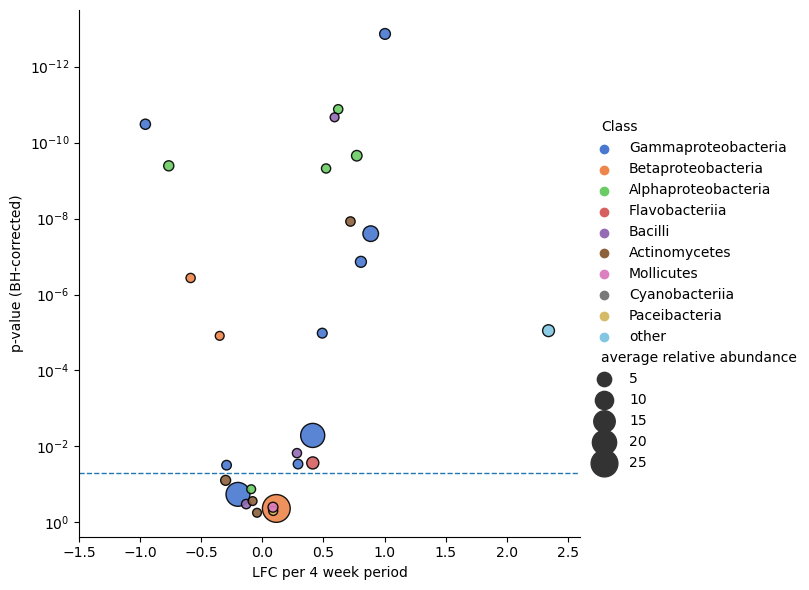

In [17]:
plotdf = dfs['positive'][(dfs['positive']['level'] =='genus')\
][['level','mean ra','prevalence','days_Since_May1 Value',
   'days_Since_May1 bh', 'days_Since_May1 Pvalue']].sort_values(by='prevalence',ascending=False)
plotdf['month change']=plotdf['days_Since_May1 Value'] * 28
plotdf['mean ra'] = plotdf['mean ra'] * 100
plotdf.rename(columns = {'mean ra': 'average relative abundance'}, inplace = True)
plotdf['Class'] =plotdf.rename(dict(zip(list(map(getname, taxa_6.index)),
    list(map(lambda x: [a for a in x.split('o__')[0].split(';') if len(a)>4][-1].strip(';'),
             taxa_6.index))))).index
plotdf['Class'].replace({'c__Gammaproteobacteria': 'Gammaproteobacteria',
                         'c__Betaproteobacteria': 'Betaproteobacteria',
                         'c__Alphaproteobacteria': 'Alphaproteobacteria',
                         'c__Flavobacteriia': 'Flavobacteriia',
                         'c__Bacilli': 'Bacilli', 'genus-other':'other',
                         'c__Actinomycetes': 'Actinomycetes', 
                         'c__Mollicutes': 'Mollicutes', 
                         'c__Cyanobacteriia': 'Cyanobacteriia', 
                         'c__Paceibacteria': 'Paceibacteria'}, inplace = True)



# plotdf['Class'].replace({'genus-other':'other','c__Actinobacteria':'Actinobacteria',
#                          'c__Bacilli':'Bacilli','c__Gammaproteobacteria': 'Gammaproteobacteria',
#         'c__Cyanobacteriia':'other','c__Bacteroidia':'Bacteroidia',
#           'c__Alphaproteobacteria':'Alphaproteobacteria', 'Unassigned':'other' ,'d__Eukaryota':'other',
#             'p__Ascomycota':'other'},inplace=True)             

fig= sns.relplot(x="month change", y="days_Since_May1 Pvalue",size="average relative abundance",
            sizes=(40, 400), alpha=.9, edgecolor='black',hue='Class',palette='muted',
            height=6, data=plotdf, linewidth=1, hue_order=[ 'Gammaproteobacteria',
            'Betaproteobacteria', 'Alphaproteobacteria', 'Flavobacteriia',
            'Bacilli','Actinomycetes', 'Mollicutes', 'Cyanobacteriia', 'Paceibacteria','other'] )


plt.yscale('log')
plt.xlim(-1.5,2.6)
plt.gca().invert_yaxis()
plt.axhline(0.05, linestyle = '--', linewidth=1)
plt.xlabel('LFC per 4 week period')
plt.ylabel('p-value (BH-corrected)')
plt.show()
fig.savefig('figs/dayosummer_volcano.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

**significant taxa**

In [21]:
dfs['positive'][dfs['positive']['days_Since_May1 bh'] < 0.05\
].sort_values(by='days_Since_May1 bh')[['level', 'mean ra','days_Since_May1 bh', 'days_Since_May1 Value']]

,level,mean ra,days_Since_May1 bh,days_Since_May1 Value
genus-f__Brucellaceae-g__Brucella,genus,0.040306,0.0,-0.049899
genus-f__Lactobacillaceae-g__Fructobacillus,genus,0.014958,0.0,0.057703
class-p__Cyanobacteria-c__Cyanobacteriia,class,0.003937,0.0,-0.04511
genus-f__Lactobacillaceae-g__Leuconostoc,genus,0.001201,0.0,0.02579
genus-f__Chloroplast-g__Chloroplast,genus,0.003934,0.0,-0.044562
class-p__Bacillota-c__Bacilli,class,0.024850,0.0,0.042031
genus-f__Erwiniaceae-g__Rosenbergiella,genus,0.015370,0.0,0.035842
genus-f__Acetobacteraceae-g__Neokomagataea,genus,0.003229,0.0,0.02217
genus-f__Lactobacillaceae-g__gbxid5846,genus,0.000530,0.0,0.021112
genus-f__Xanthomonadaceae-g__Stenotrophomonas,genus,0.010744,0.0,-0.034161


### variance explained by site vs species

In [39]:
plotdf = dfs['positive'][dfs['positive']['level']=='genus'][['1|sp__ LRT bh',
        '1|sp__ Variance','1|sp Variance','1|sp LRT bh', '1|site_year LRT bh','1|site_year Variance', 
          'mean ra']].copy()
plotdf['size'] = plotdf['mean ra'].apply(np.sqrt) 
plotdf['size'] = 240/plotdf['size'].max() * plotdf['size'] +15

plotdf['Class'] =plotdf.rename(dict(zip(list(map(getname, taxa_6.index)),
    list(map(lambda x: [a for a in x.split('o__')[0].split(';') if len(a)>4][-1].strip(';'),
             taxa_6.index))))).index
plotdf['Class'].replace({'c__Gammaproteobacteria': 'Gammaproteobacteria',
                         'c__Betaproteobacteria': 'Betaproteobacteria',
                         'c__Alphaproteobacteria': 'Alphaproteobacteria',
                         'c__Flavobacteriia': 'Flavobacteriia',
                         'c__Bacilli': 'Bacilli', 'genus-other':'other',
                         'c__Actinomycetes': 'Actinomycetes', 
                         'c__Mollicutes': 'Mollicutes', 
                         'c__Cyanobacteriia': 'Cyanobacteriia', 
                         'c__Paceibacteria': 'Paceibacteria'}, inplace = True)


/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_63987/1731834403.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plotdf['Class'].replace({'c__Gammaproteobacteria': 'Gammaproteobacteria',


In [37]:
plotdf['mean_scaled_sp_var'] = plotdf['1|sp__ Variance'] / \
                                plotdf['mean ra']
plotdf['mean_scaled_site_var'] = plotdf['1|site_year Variance'] / \
                                plotdf['mean ra']

**Total variance**

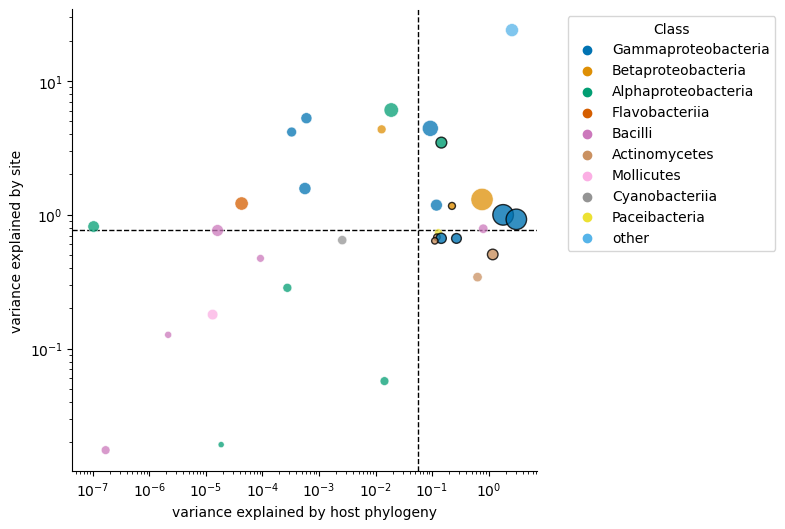

In [24]:
fig, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = plotdf[plotdf['1|sp__ LRT bh'] >0.05], x = '1|sp__ Variance', 
                y = '1|site_year Variance', s = plotdf[plotdf['1|sp__ LRT bh'] >0.05]['size'],
               hue = 'Class', legend =False, alpha=0.75,palette='colorblind',
               hue_order = [ 'Gammaproteobacteria',
            'Betaproteobacteria', 'Alphaproteobacteria', 'Flavobacteriia',
            'Bacilli','Actinomycetes', 'Mollicutes', 'Cyanobacteriia', 'Paceibacteria','other'])
sns.scatterplot(data = plotdf[plotdf['1|sp__ LRT bh'] <=0.05], x = '1|sp__ Variance', 
                y = '1|site_year Variance', s = plotdf[plotdf['1|sp__ LRT bh'] <=0.05]['size'],
               edgecolor='black',linewidth=1, color ='C0', hue = 'Class', alpha =0.8,
               palette='colorblind',
               hue_order = [ 'Gammaproteobacteria',
            'Betaproteobacteria', 'Alphaproteobacteria', 'Flavobacteriia',
            'Bacilli','Actinomycetes', 'Mollicutes', 'Cyanobacteriia', 'Paceibacteria','other'])
plt.xscale('log')
plt.yscale('log')
plt.axvline(plotdf['1|sp__ Variance'].median(), linestyle='--', linewidth=1,zorder=-1, color='black')
plt.axhline(plotdf['1|site_year Variance'].median(), linestyle='--', linewidth=1,zorder=-1, color ='black')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.05,1))
sns.despine()
plt.ylabel('variance explained by site')
plt.xlabel('variance explained by host phylogeny')

plt.savefig('figs/variance_scatter.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

**mean scaled variance**

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_63987/3628527201.py:62: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  ax.legend(ax.legend_.legendHandles[:],


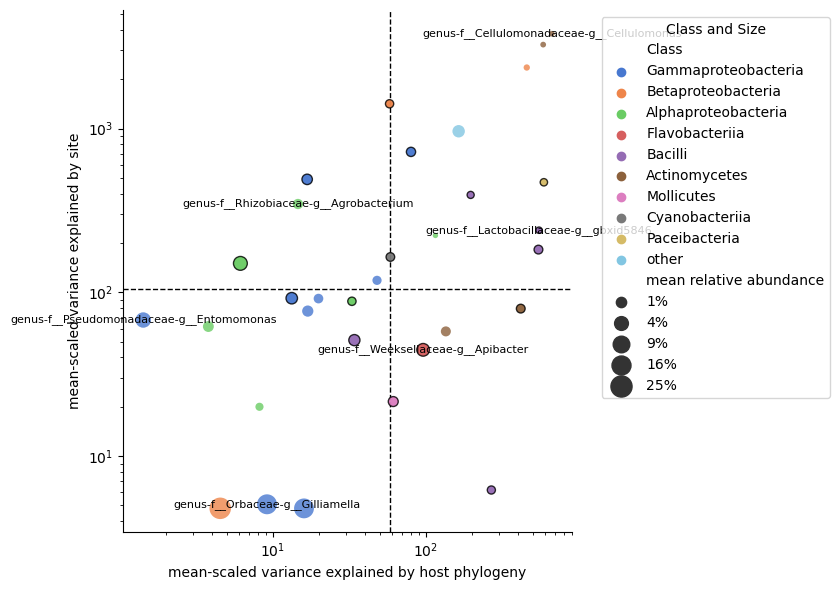

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plotdf['Total_sp_var'] = plotdf['1|sp Variance'] + plotdf['1|sp__ Variance']
plotdf['mean_scaled_sp_var'] = plotdf['Total_sp_var'] / \
                                plotdf['mean ra']
plotdf['mean_scaled_site_var'] = plotdf['1|site_year Variance'] / \
                                plotdf['mean ra']
fig, ax = plt.subplots(figsize=(8, 6))
plotdf['size'] = plotdf['mean ra'].transform(np.sqrt) 
# Define size range
min_size = plotdf['size'].min()
max_size = plotdf['size'].max()
size_ticks = [.01**.5, .05**.5, .10**.5,.20**.5]

# Base layer: all points
sns.scatterplot(
    data=plotdf,
    x='mean_scaled_sp_var',
    y='mean_scaled_site_var',
    size='size',
    hue='Class',
    palette='muted',
    hue_order=[
        'Gammaproteobacteria', 'Betaproteobacteria', 'Alphaproteobacteria',
        'Flavobacteriia', 'Bacilli', 'Actinomycetes', 'Mollicutes',
        'Cyanobacteriia', 'Paceibacteria', 'other'
    ],
    sizes=(15, 240),
    size_norm=(min_size, max_size),
    alpha=0.8,
    edgecolor='black',
    linewidth=0,
    ax=ax,
    legend='brief'
)

# Overlay layer: significant points with black outline
sns.scatterplot(
    data=plotdf[plotdf['1|sp LRT bh'] <= 0.05],
    x='mean_scaled_sp_var',
    y='mean_scaled_site_var',
    size='size',
    hue='Class',
    palette='muted',
    hue_order=[
        'Gammaproteobacteria', 'Betaproteobacteria', 'Alphaproteobacteria',
        'Flavobacteriia', 'Bacilli', 'Actinomycetes', 'Mollicutes',
        'Cyanobacteriia', 'Paceibacteria', 'other'
    ],
    sizes=(15, 240),
    size_norm=(min_size, max_size),
    alpha=0.8,
    edgecolor='black',
    linewidth=1,
    ax=ax,
    legend=False  # Don't duplicate legend
)

handles, labels = ax.get_legend_handles_labels()

ax.legend(ax.legend_.legendHandles[:], 
          labels[:11] + ['mean relative abundance'] + list(map( lambda x: str(round(x)) + '%', np.arange(0.1, 0.6, 0.1)**2 * 100)), 
          bbox_to_anchor=(1.05, 1), loc='upper left', title="Class and Size")

plt.xscale('log')
plt.yscale('log')

plt.axvline(plotdf['mean_scaled_sp_var'].median(), linestyle='--', linewidth=1,zorder=-1, color='black')
plt.axhline(plotdf['mean_scaled_site_var'].median(), linestyle='--', linewidth=1,zorder=-1, color ='black')
plt.ylabel('mean-scaled variance explained by site')
plt.xlabel('mean-scaled variance explained by host phylogeny')
plt.tight_layout()
sns.despine()
for idx, row in plotdf.loc[[x for x in plotdf.index if any(y in x for y in\
                 ['Ento', 'Apib', 'Gillia', 'Agrobacterium'])]].iterrows():
    plt.text(row['mean_scaled_sp_var'], row['mean_scaled_site_var'], 
             row.name, fontsize=8, ha='center', va='center')

#plt.show()
# plt.savefig('figs/mean_scaled_variance_scatter.pdf',
#                 format = 'pdf', transparent = True, bbox_inches='tight')

### Variance vs LFC

**fancy colors version**

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_63987/3787166772.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('turbo')
/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_63987/3787166772.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=plotdf.loc[['genus-other']].join(dfs['positive'][['Positive Value']]),


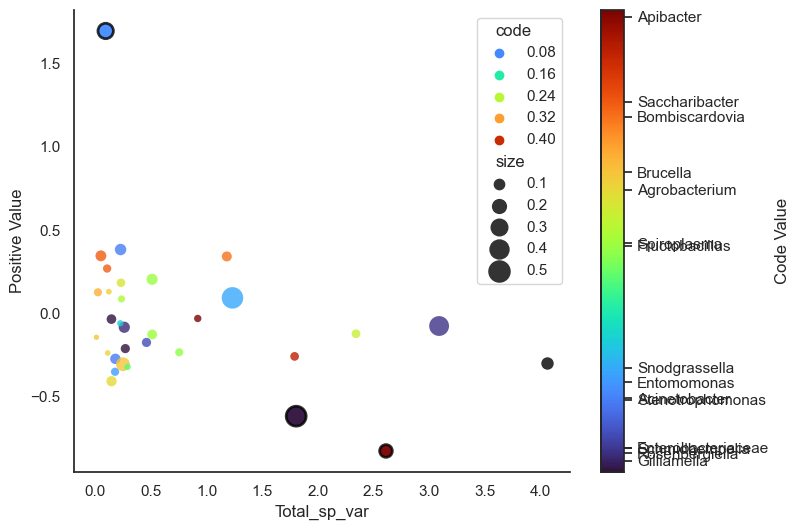

In [322]:
plotdf['genus'] = list(map(lambda x: x.split('__')[-1], plotdf.index))
sns.set(style = 'white')
fig, ax = plt.subplots(figsize=(8,6))
norm = Normalize(vmin=0, vmax=.45)
cmap = get_cmap('turbo')
colors = cmap(norm(codes))

of_interest =list(genus_colors.loc[list(set([x for x in plotdf['genus'] if x in genus_colors.index]))].index)
codes = list(genus_colors.loc[list(set([x for x in plotdf['genus'] if x in genus_colors.index]))].apply(lambda x: x if x<0.45 else 0.45))
plotdf['code'] = plotdf['genus'].map(dict(zip(of_interest, codes)))



sns.scatterplot(data=plotdf.join(dfs['positive'][['Positive Value']]),
                x='Total_sp_var', 
                y='Positive Value',
                size='size',
                hue='code',
                palette=cmap,
                sizes=(15, 240),
                size_norm=(min_size, max_size),
                alpha=0.8,
                edgecolor='black',
                linewidth=0)
sns.scatterplot(data=plotdf.join(dfs['positive'][dfs['positive'\
                    ]['Positive bh'] < 0.1][['Positive Value']]).dropna(),
                x='Total_sp_var', 
                y='Positive Value',
                size='size',
                hue='code',
                palette=cmap,
                sizes=(15, 240),
                size_norm=(min_size, max_size),
                alpha=0.8,
                edgecolor='black',
                linewidth=2, legend = False)

sns.scatterplot(data=plotdf.loc[['genus-other']].join(dfs['positive'][['Positive Value']]),
                x='Total_sp_var', 
                y='Positive Value',
                size='size',
                color='black',
                palette=cmap,
                sizes=(15, 240),
                size_norm=(min_size, max_size),
                alpha=0.8,
                edgecolor='black',
                linewidth=0, legend = False)


sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Code Value")


of_interest =list(map(lambda x: x.split('__')[-1], taxa_6_norm.mean().sort_values()[-15:].index))
codes = genus_colors.loc[of_interest].apply(lambda x: x if x<0.5 else 0.45)

cbar.set_ticks(codes)
cbar.set_ticklabels(of_interest)
sns.despine()
plt.show()
fig.savefig('figs/variance_lfc_scatter.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')


In [366]:
# Calculate OLS trendline
x = plotdf.join(dfs['positive'][['Positive Value']])['Total_sp_var']
y = plotdf.join(dfs['positive'][['Positive Value']])['Positive Value']
regdf = plotdf.join(dfs['positive'][['Positive Value'\
]]).rename(columns = {'Positive Value': 'pos'})[['pos', 'Total_sp_var']].astype(float)
regdf['Total_sp_var'] = np.log(regdf['Total_sp_var'])
import statsmodels.formula.api as smf
smf.ols("pos ~ Total_sp_var",
         data=regdf ).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pos   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.804
Date:                Mon, 02 Jun 2025   Prob (F-statistic):             0.0605
Time:                        11:42:49   Log-Likelihood:                -15.063
No. Observations:                  32   AIC:                             34.13
Df Residuals:                      30   BIC:                             37.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1510      0.090     -1.670      0.105      -0.336       0.034
Total_sp_var    -0.0996      0.051     -1.950      0.061      -0.204       0.005
==============================================================================
Omnibus:                       31.011   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.503
Skew:                           2.048   Prob(JB):                     7.37e-19
Kurtosis:                       9.771   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_63987/684594174.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  ax.legend(ax.legend_.legendHandles[:],


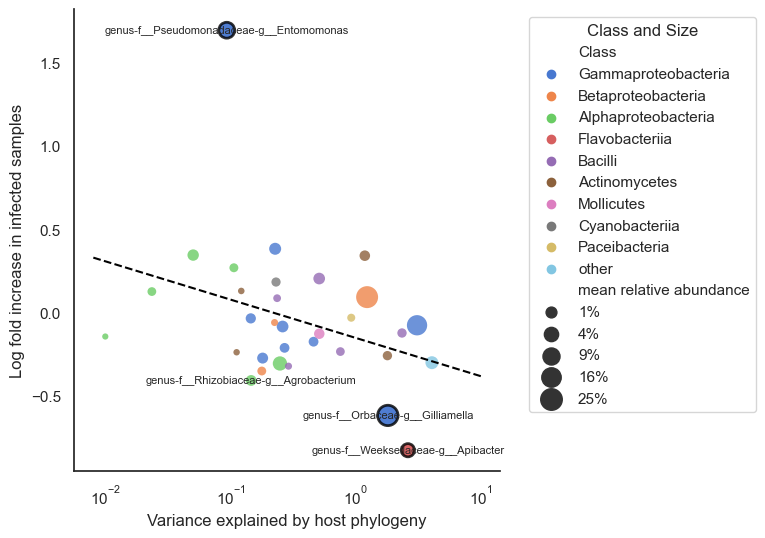

In [388]:
fig, ax = plt.subplots(figsize=(5.5,6))

sns.scatterplot(data=plotdf.join(dfs['positive'][['Positive Value']]),
                x='Total_sp_var', 
                y='Positive Value',
                size='size',
                hue='Class',
                palette='muted',
                hue_order=[
                    'Gammaproteobacteria', 'Betaproteobacteria', 'Alphaproteobacteria',
                    'Flavobacteriia', 'Bacilli', 'Actinomycetes', 'Mollicutes',
                    'Cyanobacteriia', 'Paceibacteria', 'other'
                ],
                sizes=(20, 250),
                size_norm=(min_size, max_size),
                alpha=0.8,
                edgecolor='black',
                linewidth=0)

sns.scatterplot(data=plotdf.join(dfs['positive'][dfs['positive'\
                    ]['Positive bh'] < 0.1][['Positive Value']]).dropna(),
                x='Total_sp_var', 
                y='Positive Value',
                size='size',
                hue='Class',
                palette='muted',
                hue_order=[
                    'Gammaproteobacteria', 'Betaproteobacteria', 'Alphaproteobacteria',
                    'Flavobacteriia', 'Bacilli', 'Actinomycetes', 'Mollicutes',
                    'Cyanobacteriia', 'Paceibacteria', 'other'
                ],
                sizes=(20, 250),
                size_norm=(min_size, max_size),
                alpha=0.8,
                edgecolor='black',
                linewidth=2, legend = False)


## add trendline 
x = np.linspace(.008,10)
y = -0.1510 + -0.0996*np.log(x)
sns.lineplot(x=x, y=y, color='black', linewidth=1.5, ax=ax, linestyle='--')


handles, labels = ax.get_legend_handles_labels()

ax.legend(ax.legend_.legendHandles[:], 
          labels[:11] + ['mean relative abundance'] + list(map( lambda x: str(round(x)) + '%', np.arange(0.1, 0.6, 0.1)**2 * 100)), 
          bbox_to_anchor=(1.05, 1), loc='upper left', title="Class and Size")

plt.xscale('log')
#plt.axvline(plotdf['Total_sp_var'].median(), linestyle='--', linewidth=1, zorder=-1, color='black')
plt.ylabel('Log fold increase in infected samples')
plt.xlabel('Variance explained by host phylogeny')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.05,1))
sns.despine()

for idx, row in plotdf.join(dfs['positive'][['Positive Value']]).loc[[x for x in plotdf.index if any(y in x for y in\
                 ['Ento', 'Apib', 'Gillia', 'Agrobacterium'])]].iterrows():
    plt.text(row['Total_sp_var'], row['Positive Value'], 
             row.name, fontsize=8, ha='center', va='center')

# fig.savefig('figs/variance_lfc_scatter_2.pdf',
#                format = 'pdf', transparent = True, bbox_inches='tight')


Text(0.5, 0, 'mean-scaled variance explained by host phylogeny')

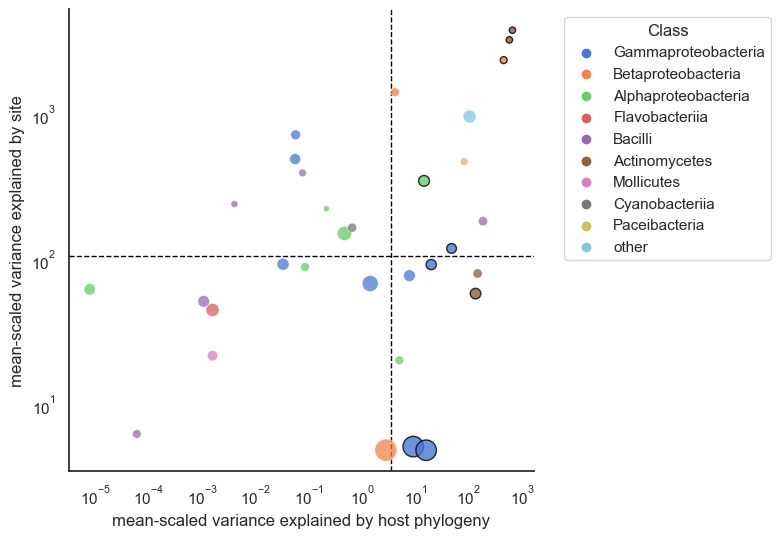

In [56]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data = plotdf[plotdf['1|sp__ LRT bh'] >0.05], x = 'mean_scaled_sp_var', 
                y = 'mean_scaled_site_var', s = plotdf[plotdf['1|sp__ LRT bh'] >0.05]['size'],
               hue = 'Class', legend =False, alpha=0.75,palette='muted',
               hue_order = [ 'Gammaproteobacteria',
            'Betaproteobacteria', 'Alphaproteobacteria', 'Flavobacteriia',
            'Bacilli','Actinomycetes', 'Mollicutes', 'Cyanobacteriia', 'Paceibacteria','other'])
sns.scatterplot(data = plotdf[plotdf['1|sp__ LRT bh'] <=0.05], x = 'mean_scaled_sp_var', 
                y = 'mean_scaled_site_var', s = plotdf[plotdf['1|sp__ LRT bh'] <=0.05]['size'],
               edgecolor='black',linewidth=1, color ='C0', hue = 'Class', alpha =0.8,
               palette='muted',
               hue_order = [ 'Gammaproteobacteria',
            'Betaproteobacteria', 'Alphaproteobacteria', 'Flavobacteriia',
            'Bacilli','Actinomycetes', 'Mollicutes', 'Cyanobacteriia', 'Paceibacteria','other'])
plt.xscale('log')
plt.yscale('log')
plt.axvline(plotdf['mean_scaled_sp_var'].median(), linestyle='--', linewidth=1,zorder=-1, color='black')
plt.axhline(plotdf['mean_scaled_site_var'].median(), linestyle='--', linewidth=1,zorder=-1, color ='black')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.05,1))
sns.despine()
plt.ylabel('mean-scaled variance explained by site')
plt.xlabel('mean-scaled variance explained by host phylogeny')

#plt.scatter(x=[0.006979446538395483], y=[69.96828482882157], marker = "*",s = 200, zorder = -1)
# plt.savefig('figs/mean_scaled_variance_scatter.pdf',
#                format = 'pdf', transparent = True, bbox_inches='tight')

### write table

In [90]:
s5 = pd.concat([dfs['positive'][dfs['positive']['level'] =='genus'][[
    'mean ra', 'prevalence', '1|sp__ Variance',
       '1|sp__ LRT Pvalue', '1|sp__ LRT bh',
       '1|sp Variance', '1|sp LRT Pvalue', '1|sp LRT bh',
       '1|site_year Variance', '1|site_year LRT Pvalue', 
       '1|site_year LRT bh', 'residual Variance', '(Intercept) Value',
       '(Intercept) Std.Error', '(Intercept) Zscore', '(Intercept) Pvalue',
       'days_Since_May1 Value', 'days_Since_May1 Std.Error',
       'days_Since_May1 Zscore', 'days_Since_May1 Pvalue', 'days_Since_May1 bh',
       'Positive Value', 'Positive Std.Error', 'Positive Zscore', 'Positive Pvalue', 
       'Positive bh']].sort_values(by = 'mean ra', ascending = False), 
       dfs['positive'][dfs['positive']['level'] =='class'][[
    'mean ra', 'prevalence', '1|sp__ Variance',
       '1|sp__ LRT Pvalue', '1|sp__ LRT bh',
       '1|sp Variance', '1|sp LRT Pvalue', '1|sp LRT bh',
       '1|site_year Variance', '1|site_year LRT Pvalue', 
       '1|site_year LRT bh', 'residual Variance', '(Intercept) Value',
       '(Intercept) Std.Error', '(Intercept) Zscore', '(Intercept) Pvalue',
       'days_Since_May1 Value', 'days_Since_May1 Std.Error',
       'days_Since_May1 Zscore', 'days_Since_May1 Pvalue', 'days_Since_May1 bh',
       'Positive Value', 'Positive Std.Error', 'Positive Zscore', 'Positive Pvalue', 
       'Positive bh']].sort_values(by = 'mean ra', ascending = False)])
s5.index = list(map(lambda x: '-'.join(x.split('-')[1:]), s5.index))
s5.to_csv('../data/table/table_s5.tsv', sep ='\t')


s6 = pd.concat([dfs['load'][dfs['load']['level'] =='genus'][[
    'mean ra', 'prevalence', '1|sp__ Variance',
       '1|sp__ LRT Pvalue', '1|sp__ LRT bh',
       '1|sp Variance', '1|sp LRT Pvalue', '1|sp LRT bh',
       '1|site_year Variance', '1|site_year LRT Pvalue', 
       '1|site_year LRT bh', 'residual Variance', '(Intercept) Value',
       '(Intercept) Std.Error', '(Intercept) Zscore', '(Intercept) Pvalue',
       'days_Since_May1 Value', 'days_Since_May1 Std.Error',
       'days_Since_May1 Zscore', 'days_Since_May1 Pvalue', 'days_Since_May1 bh',
       'log_CBombi Value', 'log_CBombi Std.Error', 'log_CBombi Zscore', 'log_CBombi Pvalue', 
       'log_CBombi bh']].sort_values(by = 'mean ra', ascending = False), 
       dfs['load'][dfs['load']['level'] =='class'][[
    'mean ra', 'prevalence', '1|sp__ Variance',
       '1|sp__ LRT Pvalue', '1|sp__ LRT bh',
       '1|sp Variance', '1|sp LRT Pvalue', '1|sp LRT bh',
       '1|site_year Variance', '1|site_year LRT Pvalue', 
       '1|site_year LRT bh', 'residual Variance', '(Intercept) Value',
       '(Intercept) Std.Error', '(Intercept) Zscore', '(Intercept) Pvalue',
       'days_Since_May1 Value', 'days_Since_May1 Std.Error',
       'days_Since_May1 Zscore', 'days_Since_May1 Pvalue', 'days_Since_May1 bh',
       'log_CBombi Value', 'log_CBombi Std.Error', 'log_CBombi Zscore', 'log_CBombi Pvalue', 
       'log_CBombi bh']].sort_values(by = 'mean ra', ascending = False)])
s6.index = list(map(lambda x: '-'.join(x.split('-')[1:]), s6.index))
s6.to_csv('../data/table/table_s6.tsv', sep ='\t')




In [88]:
dfs['load']

,level,1|sp Variance,1|sp LRT Pvalue,1|sp__ Variance,1|sp__ LRT Pvalue,1|site_year Variance,1|site_year LRT Pvalue,residual Variance,residual LRT Pvalue,(Intercept) Value,...,log_CBombi Pvalue,1|sp LRT bh,1|sp__ LRT bh,1|site_year LRT bh,residual LRT bh,(Intercept) bh,days_Since_May1 bh,log_CBombi bh,mean ra,prevalence
class-p__Pseudomonadota-c__Betaproteobacteria,class,0.7156,0.00181,0.22,0.280235,0.7906,0.0,4.8133,1.0,-1.778432,...,0.233471,0.003982,1.0,0.0,1.0,0.004977,0.226109,0.366883,0.276559,0.995298
genus-f__Bifidobacteriaceae-g__Bifidobacterium,genus,1.1098,0.00093,0.6431,0.126173,0.4259,0.000006,4.8423,1.0,-10.420689,...,0.2174,0.003305,0.336461,0.000009,1.0,0.0,0.0,0.463787,0.004304,0.398119
genus-f__Cellulomonadaceae-g__Cellulomonas,genus,0.01733,0.399682,0.13643,0.005182,0.48151,0.0,1.67368,1.0,-9.858388,...,0.03878,0.532909,0.027638,0.0,1.0,0.0,0.080909,0.15512,0.000168,0.184953
class-p__Mycoplasmatota-c__Mollicutes,class,0.456,0.0,0.000021,1.0,0.1653,0.002568,3.415,1.0,-11.78813,...,0.40208,0.0,1.0,0.003532,1.0,0.0,0.138666,0.55286,0.008358,0.115987
genus-f__Enterobacteriaceae-g__Escherichia,genus,0.005579,0.430458,0.08177,0.04511,0.24492,0.0,0.64136,1.0,-10.423562,...,0.05618,0.550986,0.160391,0.0,1.0,0.0,0.142831,0.199751,NaN,NaN
class-p__Pseudomonadota-c__Alphaproteobacteria,class,0.399403,0.002703,0.000723,1.0,4.408901,0.0,9.676635,1.0,-7.511715,...,0.1214,0.004956,1.0,0.0,1.0,0.0,0.284207,0.222567,0.080469,0.791536
genus-f__Moraxellaceae-g__Acinetobacter,genus,0.001668,1.0,0.207838,0.028259,1.627368,0.0,6.682856,1.0,-10.604647,...,0.017456,1.0,0.113037,0.0,1.0,0.0,0.002261,0.111718,0.017055,0.652038
genus-f__Lactobacillaceae-g__Apilactobacillus,genus,0.6783,0.0,0.000037,1.0,0.000009,1.0,4.538,1.0,-11.475367,...,0.38687,0.0,1.0,1.0,1.0,0.0,0.072407,0.619636,0.002819,0.235110
genus-f__Oxalobacteraceae-g__Massilia,genus,0.00002,1.0,0.2582,0.000071,1.054,0.0,1.733,1.0,-9.389729,...,0.6723,1.0,0.000568,0.0,1.0,0.0,0.000007,0.7968,0.000493,0.192790
genus-f__Acetobacteraceae-g__Saccharibacter,genus,0.08675,0.050599,0.000003,1.0,0.8414,0.000001,5.087,1.0,-12.093843,...,0.2886,0.095245,1.0,0.000002,1.0,0.0,0.0,0.527787,0.013213,0.233542


In [82]:
s5.loc[[x for x in s5.index if 'other' in x]]

,mean ra,prevalence,1|sp__ Variance,1|sp__ LRT Pvalue,1|sp__ LRT bh,1|sp Variance,1|sp LRT Pvalue,1|sp LRT bh,1|site_year Variance,1|site_year LRT Pvalue,...,days_Since_May1 Value,days_Since_May1 Std.Error,days_Since_May1 Zscore,days_Since_May1 Pvalue,days_Since_May1 bh,Positive Value,Positive Std.Error,Positive Zscore,Positive Pvalue,Positive bh
other,0.059931,0.913793,2.589,0.076501,0.222548,1.476,0.193362,0.309379,23.919,0.0,...,0.083605,0.018825,4.4412,0.000009,0.000018,-0.299453,0.827291,-0.362,0.7174,0.791614
other,0.001412,0.529781,0.01831,1.0,1.0,5.13556,0.002431,0.004457,85.12874,0.0,...,-0.011104,0.024866,-0.4466,0.655188,0.655188,3.906541,1.074044,3.6372,0.000276,0.003032
other,0.059931,0.913793,2.589,0.076501,0.222548,1.476,0.193362,0.309379,23.919,0.0,...,0.083605,0.018825,4.4412,0.000009,0.000018,-0.299453,0.827291,-0.362,0.7174,0.791614
other,0.001412,0.529781,0.01831,1.0,1.0,5.13556,0.002431,0.004457,85.12874,0.0,...,-0.011104,0.024866,-0.4466,0.655188,0.655188,3.906541,1.074044,3.6372,0.000276,0.003032


## Severity vs positivity results

In [74]:
comparedf = dfs['positive'][['mean ra', 'prevalence','level','Positive Value',
    'Positive bh']].join(dfs['load'][['log_CBombi bh', 'log_CBombi Pvalue',
                'log_CBombi Value']]).copy()
comparedf['log_CBombi bh'] = comparedf['log_CBombi bh'].fillna(1)
comparedf['log_CBombi bh'].replace(0, comparedf[comparedf['log_CBombi bh'] > 0]['log_CBombi bh'].min()/2, inplace=True)
comparedf['log_CBombi Value'] = comparedf['log_CBombi Value'].fillna(0)
comparedf['severity_size'] = 1/comparedf['log_CBombi bh'].apply(lambda x: x if x> 0.01 else 0.01)
comparedf['pos_size'] = 1/comparedf['Positive bh'].fillna(1).apply(lambda x: x if x> 0.01 else 0.01)

base = comparedf[['severity_size', 'pos_size']].min().min()
top = comparedf[['severity_size', 'pos_size']].max().max()

comparedf['severity_size'] = (np.log(comparedf['severity_size']) - \
    np.log(base)) / (np.log(top) - np.log(base)) * 400 + 20
comparedf['pos_size'] = (np.log(comparedf['pos_size']) - \
    np.log(base)) / (np.log(top) - np.log(base)) * 400 + 20




/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_13319/2779260317.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparedf['log_CBombi bh'] = comparedf['log_CBombi bh'].fillna(1)
/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_13319/2779260317.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original ob

In [77]:
scipy.stats.spearmanr(comparedf['Positive Value'], comparedf['log_CBombi Value'])

SignificanceResult(statistic=0.8131843237937023, pvalue=3.465048775284131e-11)

In [79]:
comparedf[comparedf['log_CBombi bh'] < 0.1]

,mean ra,prevalence,level,Positive Value,Positive bh,log_CBombi bh,log_CBombi Pvalue,log_CBombi Value,severity_size,pos_size
genus-f__Orbaceae-g__Gilliamella,0.196795,0.967085,genus,-0.615516,0.094769,0.014734,0.001381,-0.106764,386.336653,224.666679
genus-f__Weeksellaceae-g__Apibacter,0.027237,0.402821,genus,-0.823849,0.094769,0.014734,0.001353,-0.126539,386.336653,224.666679
class-p__Bacteroidota-c__Flavobacteriia,0.028818,0.457680,class,-0.70648,0.12914,0.044627,0.008114,-0.104377,290.080461,197.787844
class-other,0.001412,0.529781,class,3.906541,0.003032,0.005502,0.0005,0.514799,420.000000,420.000000
genus-f__Pseudomonadaceae-g__Entomomonas,0.065238,0.344828,genus,1.692192,0.0,0.002751,0,0.316588,420.000000,420.000000
genus-f__Lactobacillaceae-g__gbxid5846,0.000530,0.108150,genus,-0.320314,0.191147,0.080960,0.01012,-0.043729,238.345900,163.726654


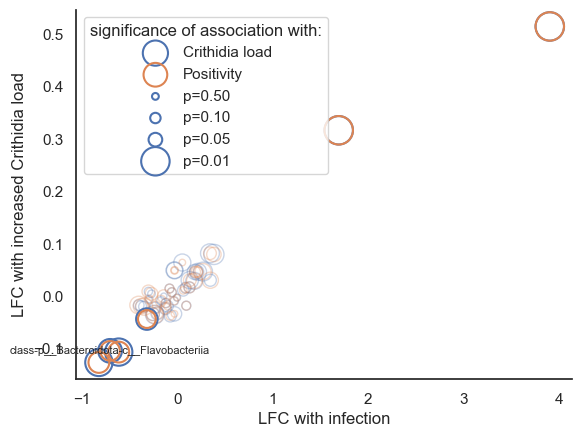

In [434]:
fig,ax = plt.subplots()
plotdf = comparedf[(comparedf['Positive bh'] < 0.1) | (comparedf['log_CBombi bh'] < 0.1)]

plotdf2 = comparedf[(comparedf['Positive bh'] > 0.1) | (comparedf['log_CBombi bh'] > 0.1)]

sns.scatterplot(data = plotdf2, x = 'Positive Value', y = 'log_CBombi Value', 
           s = plotdf2['severity_size'], edgecolor = 'C0', color = 'none',
               linewidth=1, alpha = 0.3)

sns.scatterplot(data = plotdf2, x = 'Positive Value', y = 'log_CBombi Value', 
           s = plotdf2['pos_size'], edgecolor = 'C1', color = 'none',
               linewidth=1, alpha = 0.3)

sns.scatterplot(data = plotdf, x = 'Positive Value', y = 'log_CBombi Value', 
           s = plotdf['severity_size'], edgecolor = 'C0', color = 'none',
               linewidth=1.5, label = 'Crithidia load')

sns.scatterplot(data = plotdf, x = 'Positive Value', y = 'log_CBombi Value', 
           s = plotdf['pos_size'], edgecolor = 'C1', color = 'none',
               linewidth=1.5, label = 'Positivity')

legend = [0.5,0.1,0.05,0.01]
sizes = [(1/l-base)/(top-base)*400+20 for l in legend]

for i, (l, s) in enumerate(zip(legend, sizes)):
    ax.scatter([], [], s=s, edgecolor='C0', color='none', linewidth=1.5, 
               label=f'p={l:.2f}')

count = 0
for name, row in plotdf[(plotdf['Positive bh'] < 0.1) | (plotdf['log_CBombi bh'] < 0.1)].iterrows():
    if count >1:
        ax.text(row['Positive Value'], row['log_CBombi Value'], name, fontsize=8,
             ha='center', va='center')
    count += 1
    if count > 2:
        break

plt.xlabel('LFC with infection')
plt.ylabel('LFC with increased Crithidia load')
plt.legend(title = 'significance of association with:')

sns.despine()


# plt.savefig('figs/severity_scatter.pdf',
#                format = 'pdf', transparent = True, bbox_inches='tight')



## relative abundance plot with Crithidia overlay

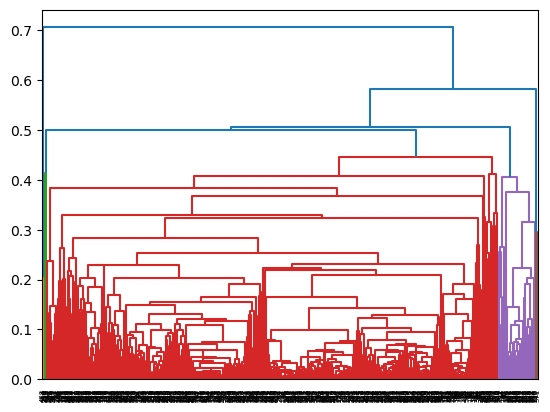

In [24]:
clusters= scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(wu_df),
                                          'average',optimal_ordering = True)
d = scipy.cluster.hierarchy.dendrogram(clusters)
index_ordered = wu_df.iloc[d['leaves']].index

In [25]:
coretaxa = [x for x in dfs['positive'].index if any( y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac',
                            'Orba'])]

ranking = pd.DataFrame(dfs['positive'][['Positive Value', 
                    'mean ra', 'prevalence']].apply(lambda x: x['mean ra']+x['prevalence'] - \
                                x['Positive Value'],axis=1).sort_values(),
                      columns = ['score'])
ranking.loc[coretaxa, 'score'] = ranking.loc[coretaxa, 'score']+.75

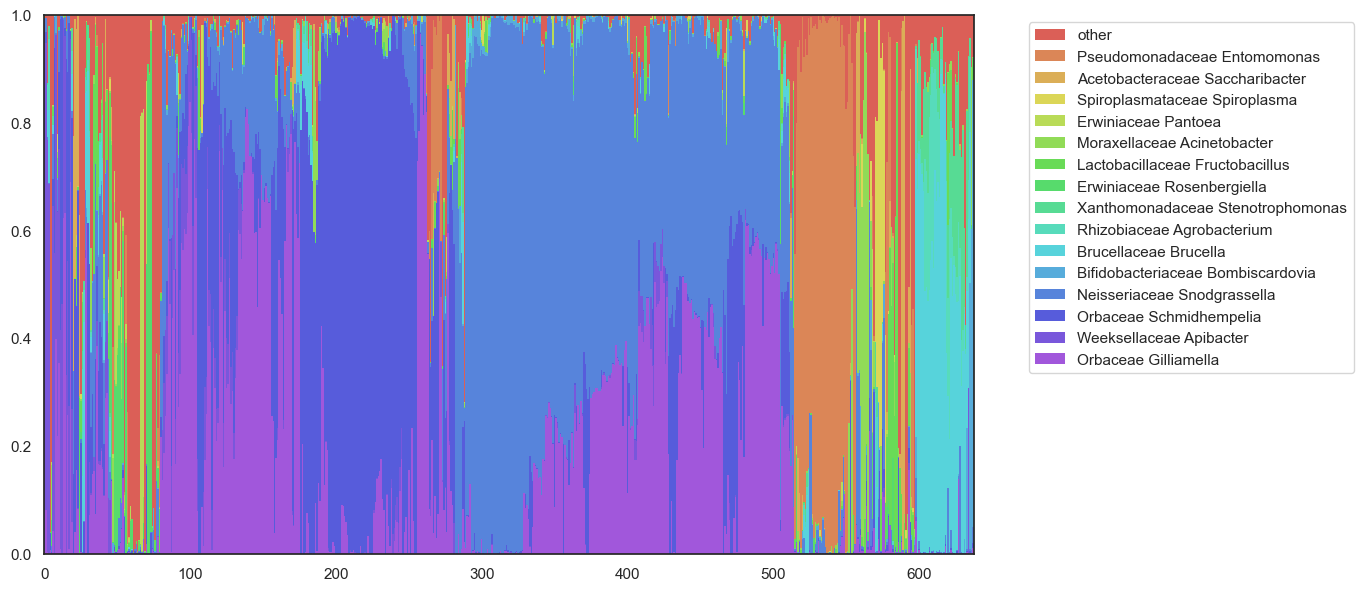

In [26]:
plotdf = taxa_6_norm.loc[index_ordered].copy()

plotdf.rename(columns = dict(zip(plotdf.columns, list(map(getname,plotdf.columns)))),
             inplace=True)
plotdf = plotdf[list(set(plotdf.columns).intersection(set(dfs['positive'].index)))].copy()
# sort by C. bombi association 

#get top ra taxa
plotdf = plotdf[plotdf.sum().sort_values(ascending = False)[:15].index]
# sort by mean ra + prev - c bombi assoc
plotdf = plotdf[ranking.loc[plotdf.columns].sort_values(by = 'score',ascending=False).index]
for i in range(1, plotdf.shape[1]):
    plotdf[plotdf.columns[i]] = plotdf[plotdf.columns[i]] + plotdf[plotdf.columns[i-1]]
plotdf['other'] =1
plotdf['x']=np.arange(len(plotdf))
plotdf = plotdf.iloc[:, ::-1] 

sns.set(style = 'white', palette = sns.color_palette("hls", 20))
fig, ax = plt.subplots(figsize = (12,7))
plotdf.columns = list(map(lambda x: x.replace('genus', '').replace('-g__',
    ' ').replace('-o__',' ').replace('-f__', ' ').strip(), plotdf.columns))
for c in range(1, plotdf.shape[1]):
    plt.bar(x = plotdf['x'], height = plotdf[plotdf.columns[c]],
           label = plotdf.columns[c], width = 1, edgecolor=None, linewidth=0)
plt.legend(bbox_to_anchor = (1.05, 1))
plt.xlim(0, 638)
plt.ylim(0,1)
fig.savefig('taxabarplot.pdf', bbox_inches='tight', transparent=True,
           format='pdf')

In [27]:
pd2 = plotdf[['x']].join(bombusMeta[['Positive', 'CBombiConc']])
def get_sliding_pos(center):
    window = 20
    #center =5 
    round = True
    temp = pd2[(pd2['x'] >center-window) & (pd2['x'] < center+window)].copy()
    if round:
        temp['dist'] = np.abs(temp['x'] - center)
        temp['dist'] = temp['dist'].replace(0,.1)**(-.5)
        temp['dist'] = temp['dist']  / temp['dist'].sum()
        return (temp['dist'] * temp['Positive']).sum()
    else:
        return temp['Positive'].mean()
pd2['avg_pos'] = pd2['x'].apply(get_sliding_pos)

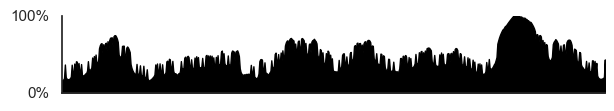

In [29]:
fig, ax = plt.subplots(figsize = (7,1))
#sns.lineplot(data = pd2, x = 'x', y = 'avg_pos')
plt.fill_between(pd2['x'], pd2['avg_pos'], color = 'black')
plt.xlim(1,637)
plt.ylim(0,1)
plt.xticks([])
sns.despine(left=False, bottom=False)
plt.yticks([0,1], ['0%', '100%'])
plt.show()
fig.savefig('infection_avg.pdf', bbox_inches='tight', transparent=True,
           format='pdf')